# Trabajo práctico integrador - Visión por Computadoras II
## Carrera de Especialización en Inteligencia Artificial - Cohorte 17
### Autores:
* Piñero, Juan Cruz 
* Lloveras, Alejandro
* Méndez, Diego Martín

**Objetivo del trabajo**

Utilizar modelos de *Computer Vision* para clasificar enfermedades de plantas (38 clases).

## Inicialización

In [ ]:
# Importación de librerías
# Gestión de archivos y reporte
import os
import shutil
import logging
import yaml

# Manipulación y análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from PIL import Image

# Machine Learning
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### Carga de datos almacenados

In [3]:
# Cargamos el dataframe desde el .CSV y definimos 'id' como índice
try:
    df = pd.read_csv('dataframe.csv').set_index('id')
except FileNotFoundError:
    print(f"Error: El archivo 'dataframe.csv' no se encontró en la ubicación actual: {os.getcwd()}")
    print("Se creará nuevamente al correr las celdas de 'Importación de imágenes'.")
    df = None
except Exception as e:
    print(f"Ocurrió un error al leer el archivo CSV: {e}")
    df = None

In [ ]:
# Cargar variables desde el archivo YAML
try:
    # Verificar si el archivo YAML existe
    yaml_filename = "constants.yaml"
    with open(yaml_filename, "r") as yaml_file:
        constants_data = yaml.safe_load(yaml_file)

    # Acceder a las variables
    ROOT_DIR = constants_data.get("ROOT_DIR")
    DATASET_PATH = constants_data.get("DATASET_PATH")
    SPLITTED_PATH = constants_data.get("SPLITTED_PATH")

    print(f"✅ Se han cargado las variables de configuración desde '{yaml_filename}'")
    print(f" - ROOT_DIR: {ROOT_DIR}")
    print(f" - DATASET_PATH: {DATASET_PATH}")
    print(f" - SPLITTED_PATH: {SPLITTED_PATH}")
except FileNotFoundError:
    print(f"Error: El archivo 'constants.yaml' no se encontró en la ubicación actual: {os.getcwd()}")
    print("Se creará nuevamente al correr el notebook.")
    ROOT_DIR = None
    DATASET_PATH = None
    SPLITTED_PATH = None
except Exception as e:
    print(f"Ocurrió un error al leer el archivo YAML: {e}")

✅ Se han cargado las variables de configuración desde 'constants.yaml'
 - ROOT_DIR: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
 - DATASET_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3
 - SPLITTED_PATH: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/


In [5]:
# ELIMINACIÓN DEL DATASET DESCARGADO EN LOCAL
"""
# Es necesario ejetcutar antes las celdas 'Funciones necesarias'

# Busca la carpeta raíz del dataset en el directorio donde fue descargado
path_to_remove = find_path("abdallahalidev")

# Valida la operación y elimina carpetas y subcarpetas
import shutil
if os.path.exists(path_to_remove):
    respuesta = input(f"¿Estás seguro de que deseas eliminar la carpeta y todo su contenido? [Y/N] {path_to_remove} :").lower()
    if respuesta == 'y':
        try:
            shutil.rmtree(path_to_remove)
            print(f"Se eliminó correctamente la carpeta y su contenido: {path_to_remove}")
        except OSError as e:
            print(f"Error al eliminar la carpeta {path_to_remove}: {e}")
    else:
        print(f"Operación de eliminación cancelada por el usuario para: {path_to_remove}")
else:
    print(f"La carpeta no existe: {path_to_remove}")
"""

'\n# Es necesario ejetcutar antes las celdas \'Funciones necesarias\'\n\n# Busca la carpeta raíz del dataset en el directorio donde fue descargado\npath_to_remove = find_path("abdallahalidev")\n\n# Valida la operación y elimina carpetas y subcarpetas\nimport shutil\nif os.path.exists(path_to_remove):\n    respuesta = input(f"¿Estás seguro de que deseas eliminar la carpeta y todo su contenido? [Y/N] {path_to_remove} :").lower()\n    if respuesta == \'y\':\n        try:\n            shutil.rmtree(path_to_remove)\n            print(f"Se eliminó correctamente la carpeta y su contenido: {path_to_remove}")\n        except OSError as e:\n            print(f"Error al eliminar la carpeta {path_to_remove}: {e}")\n    else:\n        print(f"Operación de eliminación cancelada por el usuario para: {path_to_remove}")\nelse:\n    print(f"La carpeta no existe: {path_to_remove}")\n'

### Funciones necesarias

In [6]:
import os, re

# Busca la carpeta raíz del dataset en el directorio donde fue descargado
def find_path(folder):
    match = re.search(fr"^(.*?)/{folder}/", DATASET_PATH)
    if match:
        prefix = match.group(1)
        path = os.path.join(prefix, f"{folder}/")
        return path
    else:
        print(f'No se ha podido encontrar la carpeta "{folder}" en {DATASET_PATH}')
        return None

In [7]:
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

# Dataset

El dataset es 'PlantVillage' , obtenido de Kaggle con más de 50 mil imágenes RGB de hojas de cultivos sanas y enfermas, categorizadas en 38 clases diferentes. La primera versión del dataset fue disponibilizada por David. P. Hughes, Marcel Salathe y utilizado para desarrollar el proyecto 'PlantVillage' de la universidad de Penn State.

[**Link al Paper original**](https://arxiv.org/abs/1511.08060)

## Contenido del dataset



Dentro del dataset encontramos una jerarquía de carpetas que contienen imagenes. 
En el primer nivel encontramos tres carpetas que describen el tipo de imagen segun su preprocesamiento. Estas son:

- **color**: imagenes en color
- **grayscale**: mismas imagenes pero en escala de grises. En principio es desconocido el algoritmo utilizado.
    - apriori podriamos decir que la escala de grises no es ideal para detectar anomalías en cultivos, ya que muchas enfermedades se manifiestan con una diferencia de color entre las partes afectadas y las partes no afectadas.   
- **segmented**: mismas imagenes pero despues de aplicar algún algoritmo de segmentación. En principio es desconocido el algoritmo utilizado.
    - Haciendo una inspección inicial podemos ver que no todas las segmentaciones son de buena calidad, por lo que apriori optaríamos por usar las imágenes en color, haciendo algun preprocesamiento de las mismas por nuestra cuenta si fuera necesario.


Dentro de cada una de las tres carpetas que describen el preoposesamiento (color,grayscale,segmented) encontramos 38 carpetas, cada una con sus respectivas imagenes. Los nombres de las carpetas indican tanto la especie como la enfermedad o bien la palabra 'healthy' como indicador de que la imagen es de una planta sana . Por ejemplo, la carpeta "Apple___Apple_scab" contiene imagenes de hojas de manzana con 'Sarna del manzano'.

Como se puede ver en la descripción disponible en kaggle, el número de imagenes dentro de cada clase varía entre 152 y 5507 segun la especie y la enfermedad.

En el análisis exploratorio obtenemos una tabla resumen con las especies y las enfermedades presentes en el dataset, así como la cardinalidad de cada conjunto.


### Tamaño de las imagenes
Las imágenes se encuentran normalizadas a un tamaño de 256x256 pixeles.

[**Link al Dataset**](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset)

#### Descarga de dataset de Kaggle

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", DATASET_PATH)

/opt/anaconda3/envs/cv-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


Decidimos en principio trabajar con el dataset con imágenes a color por ser el que contiene mayor información.

In [ ]:
# Ruta de acceso al dataset
ROOT_DIR = f'{DATASET_PATH}/plantvillage dataset/color'

## Descripción del problema


El objetivo es construir un modelo que permita diagnosticar las enfermedades mediante una foto de una hoja de una planta. Por lo tanto podemos diagramarlo como un problema de clasificación. Donde las clases son las enfermedades, en conjunto con la especie de la planta. En otras palabras , las clases podrían ser los nombres de las carpetas que contienen las imagenes.

### Estado del arte

La aplicación de deep learning en este problema ha permitido grandes avances en los resultados obtenidos . Con los modelos del estado del arte se alcanzan resultados de mas de 95% de accuracy en clasificación y niveles de precisión de más del 90% en problemas de detección y segmentación de plagas y enfermedades en plantas / cultivos.

### Modelo a implementar como solución

La cantidad de imágenes en cada directorio nos permite predecir que , al intentar resolver la clasificación, tendremos un problema de desbalance de clases. Por lo tanto será importante tomar esto en cuenta a la hora de elegir la métrica a utilizar en el entrenamiento del modelo.

La exactitud del modelo así planteado estará lógicamente limitada a las especies y enfermedades tratadas. Se podría tambien plantear un modelo donde se intente clasificar entre 'enferma' o 'sana' para intentar generalizar a otras especies o enfermedades, aunque esa generalización sería también muy limitada dada la diversidad de especies que existen en el mundo real. Dicho problema en principio no lo contemplaremos en este trabajo. Sólo nos vamos a limitar a clasificar entre las 38 clases presentes en el dataset.

Una forma de incorporar al modelo más complejidad e intentar abarcar otras especies podría ser utilizando Transfer Learning con un modelo pre-entrenado. Fine-tuneandolo para éste dataset. O bien utilizando técnicas / arquitecturas de Few Shot Learning. 

### Etapa de preprocesamiento

El hecho de que el dataset ya cuente con directorios donde se facilitan los datos preprocesados, nos da un indicio de que esa etapa es muy importante para el problema que se quiere resolver.

Será necesaria una etapa de preprocesamiento donde podamos aplicar algúna transformación de las imagenes para mejorar su calidad y poder obtener un mejor resultado en el entrenamiento. Dichas transformaciones podrían consistir tanto en el resize como en transformaciones de espacio de color, segmentaciones, etc. 
A modo de referencia podemos mencionar un artículo que explora el estado del arte en el tema de detección de enfermedades en plantas con Computer Vision:

[_«Trends in Machine and Deep Learning Techniques for Plant Disease Identification: A Systematic Review»_](
https://www.researchgate.net/profile/Juvenal-Rodriguez/publication/386275339_Trends_in_Machine_and_Deep_Learning_Techniques_for_Plant_Disease_Identification_A_Systematic_Review/links/674b1535f309a268c0193cd3/Trends-in-Machine-and-Deep-Learning-Techniques-for-Plant-Disease-Identification-A-Systematic-Review.pdf)

Según este artículo se destacan los siguientes items clave en el preprocesamiento de las imagenes:
- Resizing y cropping. La arquitectura a utilizar puede llegar a requerir un tamaño determinado de la imagen de entrada.
- Normalización de las imagenes. Podria ser necesario llevar los valores de los pixeles a un rango normalizado [0,1]. Esto suele mitigar los efectos de variaciones en brillo y contraste.
- Reducción de ruido.
- Data augmentation: este proceso es clave cuando se cuenta con datasets de tamaño o dispoinibilidad limitada. Se pueden aplicar operaciones variadas a las imagenes para aumentar la cantidad de datos y mejorar la generalizabilidad del modelo. Incluso se podría aplicar una GAN para generar imagenes sinteticas.
- Transformaciones de espacio de color: podria ser a escala de grises, HSV, etc.


## Importación de imágenes

In [ ]:
# CONFIGURACIÓN INICIAL:
# Separador usado en los nombres de las subcarpetas
SEPARATOR = '___' # Separa entre 'group' y 'class'

# Extensiones de archivo de imagen a considerar (en minúsculas)
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
def process_image_directory(root_dir, separator='___', valid_extensions=None):
    """
    Recorre un directorio raíz, extrae rutas de imágenes y metadatos de subcarpetas.

    Args:
        root_dir (str): La ruta al directorio raíz que contiene las subcarpetas de clases.
        separator (str): El separador utilizado en los nombres de las subcarpetas
                         para dividir 'group' y 'class'.
        valid_extensions (set, optional): Un conjunto de extensiones de archivo (en minúsculas,
                                          incluyendo el punto) a considerar como imágenes.
                                          Si es None, se usará un conjunto predeterminado.

    Returns:
        pandas.DataFrame: Un DataFrame con las columnas 'image_path', 'filename', 'group', 'class'.
                          Retorna un DataFrame vacío si el directorio raíz no existe o
                          no se encuentran imágenes válidas.
    """
    if valid_extensions is None:
        valid_extensions = IMAGE_EXTENSIONS # Verifica que sean archivos de imagen

    data = []
    output_columns = ['image_path', 'filename', 'class', 'group', 'tag'] # Define la estructura para el Dataframe

    if not os.path.isdir(root_dir):
        logging.error(f"El directorio raíz especificado no existe: {root_dir}")
        return pd.DataFrame(data, columns=output_columns) # Asegura que exista el directorio

    logging.info(f"Comenzando el procesamiento del directorio: {root_dir}")

    # Exploración de cada sucarpeta
    for entry in os.scandir(root_dir):
        if entry.is_dir():
            subdir_name = entry.name
            subdir_path = entry.path
            logging.info(f"Procesando subdirectorio: {subdir_name}")

            if separator in subdir_name:
                try:
                    group_name, tag = subdir_name.split(separator, 1)
                except ValueError:
                    logging.warning(f"No se pudo dividir el nombre '{subdir_name}' usando '{separator}'. Saltando directorio.")
                    continue

                for sub_entry in os.scandir(subdir_path):
                    if sub_entry.is_file():
                        file_name = sub_entry.name
                        file_path = sub_entry.path

                        _, extension = os.path.splitext(file_name)
                        if extension.lower() in valid_extensions:
                            relative_path = os.path.relpath(os.path.dirname(file_path), root_dir) # Carpeta dónde encontrar a imagen
                            
                            # Almacena toda la información
                            data.append({
                                'image_path': f"{relative_path}/",
                                'filename': file_name,
                                'class': relative_path,
                                'group': group_name,
                                'tag': tag
                            })
                        else:
                            logging.debug(f"Archivo omitido (no es imagen válida): {file_path}")
            else:
                logging.warning(f"El nombre del subdirectorio '{subdir_name}' no contiene el separador '{separator}'. Saltando.")

    if not data:
        logging.warning("No se encontraron imágenes válidas en la estructura de directorios especificada.")

    # Construye el DataFrame
    df = pd.DataFrame(data, columns=output_columns)
    logging.info(f"Proceso completado. Se encontraron {len(df)} imágenes.")
    return df

In [ ]:
# Descomentar en caso de querer generarlo nuevamente el Dataframe
# del df

In [169]:
# Verificación de importación de Dataframe del CSV
build_df = False # inicializa el estado

try:
    if df is None:
        # No se ha podido importar el CSV
        build_df = True
    else:
        # El Dataframe ya ha sido cargado en memoria
        build_df = False
except NameError:
    # Cuando la variable 'df' aún no ha sido definida
    build_df = True

In [ ]:
if build_df:
    print("El Dataframe aún no ha sido creado, se procede a su construcción:")
    df = process_image_directory(ROOT_DIR)
else:
    print("El Dataframe ya ha sido importado, por lo que por eficiencia no se ejecutará nuevamente.\nEn caso de querer generarlo nuevamente descomentar las celdas anteriores y ejecutar nuevamente.")

2025-04-05 20:38:43,505 - INFO - Comenzando el procesamiento del directorio: /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
2025-04-05 20:38:43,507 - INFO - Procesando subdirectorio: Strawberry___healthy
2025-04-05 20:38:43,526 - INFO - Procesando subdirectorio: Grape___Black_rot
2025-04-05 20:38:43,554 - INFO - Procesando subdirectorio: Potato___Early_blight
2025-04-05 20:38:43,572 - INFO - Procesando subdirectorio: Blueberry___healthy
2025-04-05 20:38:43,598 - INFO - Procesando subdirectorio: Corn_(maize)___healthy
2025-04-05 20:38:43,619 - INFO - Procesando subdirectorio: Tomato___Target_Spot
2025-04-05 20:38:43,648 - INFO - Procesando subdirectorio: Peach___healthy
2025-04-05 20:38:43,654 - INFO - Procesando subdirectorio: Potato___Late_blight
2025-04-05 20:38:43,690 - INFO - Procesando subdirectorio: Tomato___Late_blight
2025-04-05 20:38:43,737 - INFO - Procesando subdirectorio: Tomato___Tomato_mosaic_vi

In [63]:
df.sample(5)

,image_path,filename,class,group,tag
32676,Tomato___Tomato_Yellow_Leaf_Curl_Virus/,1cd0ab0b-f4cf-4f2f-960a-455de4cd4c1e___YLCV_GC...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus
46177,Apple___Black_rot/,50755673-3ea3-4e06-acbb-703413571a91___JR_FrgE...,Apple___Black_rot,Apple,Black_rot
11065,"Pepper,_bell___healthy/",a8d0f75a-6f10-44db-b6c4-72f19646167d___JR_HL 5...,"Pepper,_bell___healthy","Pepper,_bell",healthy
28529,Tomato___healthy/,8f009cfa-d6f0-4e8b-8950-71638f04d2c1___RS_HL 0...,Tomato___healthy,Tomato,healthy
44581,Squash___Powdery_mildew/,f7ed022b-2f5a-475d-ad90-bb6d162bbe3f___MD_Powd...,Squash___Powdery_mildew,Squash,Powdery_mildew


In [84]:
# Mueve el índice a una columna 'id' para poder tener un control de los datos durante el proceso de ETL
df = df.reset_index(names='id')

# Define la columna 'id' como index
df = df.set_index('id')

df.sample(5)

,image_path,filename,class,group,tag
id,,,,,
11480,"Pepper,_bell___healthy/",c0466e8b-d9cd-4bad-83c0-e8813b17788c___JR_HL 8...,"Pepper,_bell___healthy","Pepper,_bell",healthy
50958,Soybean___healthy/,d6b09d1b-49c8-46b8-b3c0-1c07d0b8e01f___RS_HL 3...,Soybean___healthy,Soybean,healthy
14769,Orange___Haunglongbing_(Citrus_greening)/,331ade5c-7616-4b52-97a2-39908eb8ee29___CREC_HL...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
25345,Corn_(maize)___Common_rust_/,RS_Rust 1815.JPG,Corn_(maize)___Common_rust_,Corn_(maize),Common_rust_
30342,Tomato___Tomato_Yellow_Leaf_Curl_Virus/,b31c5bf6-8fbe-4346-a2d4-c4eb1c3a2435___YLCV_NR...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus


In [85]:
# Guardamos el dataframe como .CSV para evitar realizar este proceso nuevamente
df.to_csv('dataframe.csv')

# Análisis exploratorio (EDA)

## Información general

In [ ]:
# Verificamos la importación
df.sample(5)

,image_path,filename,class,group,tag
id,,,,,
16299,Orange___Haunglongbing_(Citrus_greening)/,c3761f85-eb13-446a-a673-19993d0a73dc___CREC_HL...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)
6777,Peach___healthy/,04c14871-257f-4067-80f7-ecc5e50f42a4___Rutg._H...,Peach___healthy,Peach,healthy
6449,Tomato___Target_Spot/,01e0b8b1-e713-4c6d-973b-f7636280c58a___Com.G_T...,Tomato___Target_Spot,Tomato,Target_Spot
40489,Peach___Bacterial_spot/,82d203aa-eb50-4e38-b64b-0976fbcfb474___Rut._Ba...,Peach___Bacterial_spot,Peach,Bacterial_spot
12297,Orange___Haunglongbing_(Citrus_greening)/,2063fc79-fd1b-4669-8f0b-aeefb1a433cb___UF.Citr...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54305 entries, 0 to 54304
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  54305 non-null  object
 1   filename    54305 non-null  object
 2   class       54305 non-null  object
 3   group       54305 non-null  object
 4   tag         54305 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


Verificamos que no hay valores nulos en las tiquetas, carpetas vacías, ni errores en el procesamiento del dataset.

In [ ]:
df.describe()

,image_path,filename,class,group,tag
count,54305,54305,54305,54305,54305
unique,38,54305,38,14,21
top,Orange___Haunglongbing_(Citrus_greening)/,c7f4b7b2-b13c-476e-a936-c91ce39749a3___RS_HL 6...,Orange___Haunglongbing_(Citrus_greening),Tomato,healthy
freq,5507,1,5507,18160,15084


## Visualización de imágenes

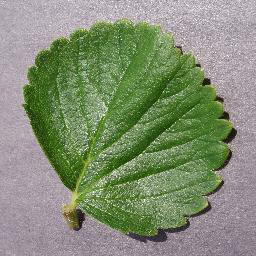

In [8]:
# Permite visualizar una imagen específica (con iloc)
id = 0 # Indice de la imagen a cargar
image = load_image(data=df, index=id, root=ROOT_DIR)

#image.show() #popup option
image

Visualizando 10 imágenes aleatorias:
Imagen #1 (Índice: 51482):


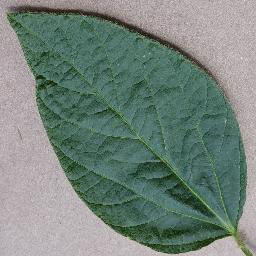

Imagen #2 (Índice: 36574):


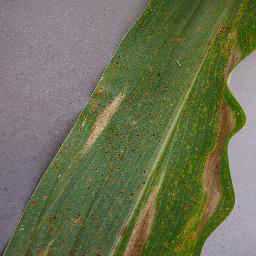

Imagen #3 (Índice: 11431):


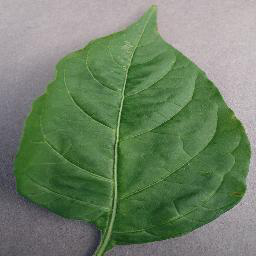

Imagen #4 (Índice: 2653):


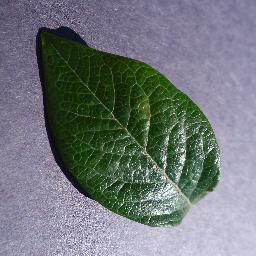

Imagen #5 (Índice: 19158):


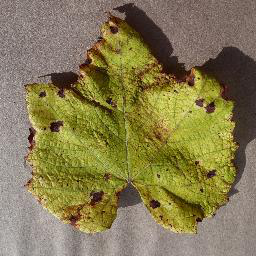

Imagen #6 (Índice: 42733):


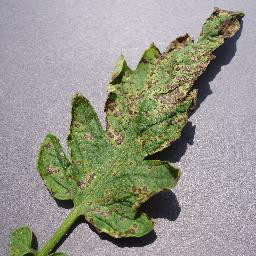

Imagen #7 (Índice: 8820):


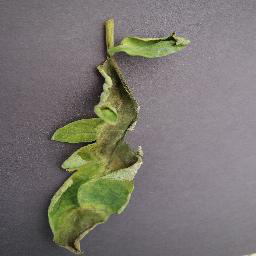

Imagen #8 (Índice: 12377):


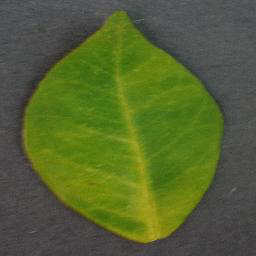

Imagen #9 (Índice: 48358):


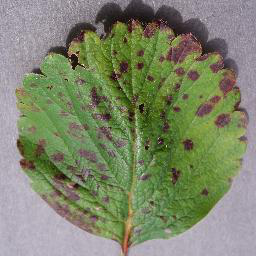

Imagen #10 (Índice: 37101):


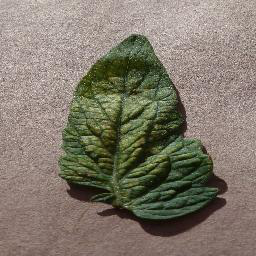

In [9]:
import random

# Obtener 10 índices aleatorios del DataFrame
num_to_display = 10
random_indices = random.sample(range(len(df)), num_to_display)

print(f"Visualizando {num_to_display} imágenes aleatorias:")
for i, index in enumerate(random_indices):
    try:
        image = load_image(data=df, index=index, root=ROOT_DIR)
        print(f"Imagen #{i+1} (Índice: {index}):")
        display(image) # Muestra la imagen directamente en entornos como Jupyter Notebook
    except FileNotFoundError:
        print(f"Error: No se encontró la imagen en la ruta: {os.path.join(ROOT_DIR, df.loc[index, 'relative_path'])}")
    except Exception as e:
        print(f"Error al cargar la imagen en el índice {index}: {e}")

## Tamaño de las imágenes

In [ ]:
sizes = []
for index in range (0,df.shape[0]):
    
    image = load_image(data=df, index=index, root=ROOT_DIR)
    sizes.append(image.size)

In [ ]:
set(sizes)

{(256, 256)}

## Distribución entre clases

In [102]:
print("Conteo por grupo:")
print(df['group'].value_counts())

Conteo por grupo:
group
Tomato                     18160
Orange                      5507
Soybean                     5090
Grape                       4062
Corn_(maize)                3852
Apple                       3171
Peach                       2657
Pepper,_bell                2475
Potato                      2152
Cherry_(including_sour)     1906
Squash                      1835
Strawberry                  1565
Blueberry                   1502
Raspberry                    371
Name: count, dtype: int64


In [103]:
print("Conteo por etiqueta:")
print(df['tag'].value_counts())

Conteo por etiqueta:
tag
healthy                                15084
Haunglongbing_(Citrus_greening)         5507
Bacterial_spot                          5421
Tomato_Yellow_Leaf_Curl_Virus           5357
Late_blight                             2909
                                       ...  
Leaf_Mold                                952
Apple_scab                               630
Cercospora_leaf_spot Gray_leaf_spot      513
Tomato_mosaic_virus                      373
Cedar_apple_rust                         275
Name: count, Length: 21, dtype: int64


In [104]:
df[df['group'] == 'Raspberry']['tag'].value_counts()

tag
healthy    371
Name: count, dtype: int64

Como puede verse, todos los datos pertenecientes al grupo `Raspberry` tienen la etiqueta `helathy`.

Esto indica que no se cuenta con datos de enfermedades para esta clase.

# Dataset split

#### Funciones

In [8]:
from sklearn.model_selection import train_test_split

def split_data(df,
               target_column='class',
               test_size=0.20,
               validation_size=0.0, # Por defecto no define un conjunto de validación
               random_state=42,     # Semilla para reproducibilidad
               split_column_name='split'):
    """
    Añade una columna al DataFrame indicando la división (train/test/validation).

    Realiza una división estratificada para mantener el balance de clases.

    Args:
        df (pd.DataFrame): DataFrame de entrada con al menos la columna 'target_column'.
        target_column (str): Nombre de la columna que contiene las etiquetas de clase
                             para la estratificación (ej: 'class').
        test_size (float): Proporción del dataset a incluir en el conjunto de test (ej: 0.20).
        validation_size (float): Proporción del dataset a incluir en el conjunto de validación.
                                 La proporción de entrenamiento será 1.0 - test_size - validation_size.
                                 Si es 0.0, solo se crearán conjuntos de train y test.
        random_state (int): Semilla para el generador de números aleatorios para asegurar
                            divisiones reproducibles.
        split_column_name (str): Nombre de la nueva columna que contendrá las etiquetas
                                 'train', 'test' o 'validation'.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna 'split_column_name'.

    Raises:
        ValueError: Si test_size + validation_size >= 1.0, o si target_column no existe.
        ImportError: Si scikit-learn no está instalado.
    """
    if target_column not in df.columns:
        raise ValueError(f"La columna objetivo '{target_column}' no se encuentra en el DataFrame.")

    if not isinstance(test_size, float) or not (0.0 <= test_size < 1.0):
         raise ValueError("test_size debe ser un float entre 0.0 y 1.0.")

    if not isinstance(validation_size, float) or not (0.0 <= validation_size < 1.0):
         raise ValueError("validation_size debe ser un float entre 0.0 y 1.0.")

    if test_size + validation_size >= 1.0:
        raise ValueError("La suma de test_size y validation_size debe ser menor que 1.0.")

    # Crear la nueva columna inicializada (opcional, pero ayuda a la claridad)
    df[split_column_name] = 'unassigned'

    # Extraer etiquetas para estratificación
    labels = df[target_column]
    indices = df.index # Usaremos los índices para la división

    # --- Lógica de División ---

    # Caso 1: División en Train / Test (sin Validación)
    if validation_size == 0.0:
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=labels # Permite mantener el balance de clases
        )
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[test_indices, split_column_name] = 'test'
        logging.info(f"División completada: Train ({1-test_size:.1%}), Test ({test_size:.1%}). Estratificada por '{target_column}'.")

    # Caso 2: División en Train / Test / Validation
    else:
        # Paso 1: Dividir en (Train + Validation) y Test
        remaining_indices, test_indices = train_test_split(
            indices,
            test_size=test_size, # Tamaño final del conjunto de test
            random_state=random_state,
            stratify=labels
        )

        # Calcular el tamaño relativo de validación respecto al conjunto restante (Train + Validation)
        # Ejemplo: test=0.2, val=0.1 -> Total 0.3. Restante 0.7. val_rel = 0.1 / 0.7 = 0.142...
        # train_test_split tomará el 14.2% del 70% restante, lo que equivale al 10% del total original.
        relative_val_size = validation_size / (1.0 - test_size)

        # Obtener las etiquetas correspondientes SOLO al conjunto restante para la segunda estratificación
        remaining_labels = df.loc[remaining_indices, target_column]

        # Paso 2: Dividir el conjunto restante en Train y Validation
        train_indices, validation_indices = train_test_split(
            remaining_indices, # Dividir solo los índices restantes
            test_size=relative_val_size, # Tamaño relativo calculado
            random_state=random_state,   # Usar la misma semilla para consistencia
            stratify=remaining_labels    # Estratificar usando las etiquetas restantes
        )

        # Asignar etiquetas de división al DataFrame original
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[validation_indices, split_column_name] = 'valid'
        df.loc[test_indices, split_column_name] = 'test'

        train_actual_prop = len(train_indices) / len(df)
        val_actual_prop = len(validation_indices) / len(df)
        test_actual_prop = len(test_indices) / len(df)
        logging.info(f"División completada: Train ({train_actual_prop:.1%}), Validation ({val_actual_prop:.1%}), Test ({test_actual_prop:.1%}). Estratificada por '{target_column}'.")

    return df

In [ ]:
def dataset_already_exists(path_to_check: str) -> bool | None:
    """
    Verifica si el directorio especificado existe y está vacío.

    Args:
        path_to_check (str): Ruta del directorio a verificar.

    Returns:
        bool: True si el directorio existe y está vacío, False en caso contrario.
    """
    if not os.path.exists(path_to_check):
        # El directorio no existe -> Crea el directorio
        #print(f"☑️ El directorio no existe, aún no ha sido creado:\n > {path_to_check}") # Debugging
        return False # No realiza ninguna acción
    else:
        # Verificar si el directorio está vacío
        try:
            # Explora el contenido del directorio
            content = os.listdir(path_to_check)
            #print(content) # Debugging

            # Si el directorio está vacío, se puede eliminar directamente
            #       -> Elimina sin confirmación
            if not content:
                os.rmdir(path_to_check) # Elimina el directorio vacío
                print(f"☑️ El directorio estaba vacío y se ha eliminado de forma automática:\n > {path_to_check}\n")
                return False
            
            # Si el directorio contiene sólo archivos ocultos (de sistema)
            #       -> Elimina sin confirmación
            elif all([file.startswith('.') for file in content]):
                shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                print(f"☑️ El directorio sólo contenía archivos ocutlos, por lo que se ha eliminado de forma automática:\n > {path_to_check}\n")
                return False

            # Si hay archivos visibles en el directorio (dataset ya existe)
            #       -> Solicita permiso para eliminarlos
            else:
                # Input de confirmación del usuario
                confirmacion = input(f"⚠️ El directorio especificado ya existe y contiene archivos. ¿Deseas eliminar todo su contenido y el directorio en sí? [Y/N]: '{path_to_check}'").strip().lower()
                # Verifica la respuesta del usuario
                if confirmacion == 'y':
                    shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                    print(f"✅ El directorio y su contenido han sido eliminados exitosamente:\n > {path_to_check}\n")
                    return False
                else:
                    print(f"⛔️ La eliminación del directorio ha sido denegada por el usuario:\n  > {path_to_check}")
                    return True
        
        except OSError as e:
            print(f"❌ Error al eliminar el directorio vacío en {path_to_check}: {e}\n")
            return None
        except Exception as e:
            print(f"‼️ Ocurrió un error inesperado al intentar eliminar el directorio vacío en {path_to_check}: {e}\n")
            return None

In [ ]:
def create_ignore_function(df, train_label, filename_col='filename'):
    """
    Crea y devuelve la función 'ignore_files' que tiene acceso al DataFrame
    y sabe qué archivos mantener.
    """
    # Crea un conjunto (set) con los nombres de archivo que SÍ queremos copiar (ej: split == 'train')
    # Usa este conjunto para hacer la búsqueda de forma mucho más rápida
    files_to_keep = set(df[df['split'] == train_label][filename_col])
    #print(f"Archivos a mantener (split='{train_label}'): {files_to_keep}") # Debugging

    def ignore_files(current_dir, files_in_current_dir):
        """
        Función que será llamada por shutil.copytree.
        Decide qué archivos/directorios ignorar en el directorio actual.
        """
        ignore_list = []
        for item in files_in_current_dir:
            # Construye la ruta completa para verificar si es archivo o directorio
            full_path = os.path.join(current_dir, item)

            # Aplicar la lógica de ignorar SOLO los ARCHIVOS de la lista
            if os.path.isfile(full_path):
                # Si el nombre del archivo NO está en el conjunto de archivos a mantener,
                # entonces lo agrega a la lista de ignorados.
                if item not in files_to_keep:
                    # print(f"Ignorando archivo: {item} (en {current_dir})") # Debugging
                    ignore_list.append(item)

        # print(f"Directorio: {current_dir}, Ignorando: {ignore_list}") # Debugging
        return ignore_list

    # Devuelve la función 'ignore_files' configurada
    return ignore_files


## Divisón de datos

In [ ]:
# Disivión del dataset
# (Ejemplo: 80% train, 20% test)
try:
        df_split = split_data(df.copy(), # Usar .copy() para no modificar el original directamente aquí
                                target_column='class',
                                test_size=0.2,
                                random_state=42) # Usa la semilla que prefieras

except ValueError as e:
        print(f"\nError al dividir los datos: {e}")
except ImportError:
        print("\nError: La biblioteca scikit-learn no está instalada. Por favor, instálala con 'pip install scikit-learn'")
except Exception as e:
        print(f"\nOcurrió un error inesperado: {e}")


In [113]:
df_split.sample(5)

,image_path,filename,class,group,tag,split
id,,,,,,
12418,Orange___Haunglongbing_(Citrus_greening)/,885a6772-0c95-4805-bc03-fe7a5b07c073___CREC_HL...,Orange___Haunglongbing_(Citrus_greening),Orange,Haunglongbing_(Citrus_greening),train
3707,Blueberry___healthy/,40f80efb-32a6-4805-9c01-ada369c6900b___RS_HL 5...,Blueberry___healthy,Blueberry,healthy,test
36742,Tomato___Spider_mites Two-spotted_spider_mite/,6eb5d1ea-faf3-4a41-8419-89158aef70a5___Com.G_S...,Tomato___Spider_mites Two-spotted_spider_mite,Tomato,Spider_mites Two-spotted_spider_mite,train
19954,Cherry_(including_sour)___Powdery_mildew/,5cdf0423-83a1-42ec-97f0-4c91a6130cb4___FREC_Pw...,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour),Powdery_mildew,train
49302,Soybean___healthy/,d5006066-4ff3-4264-860d-0773a2418039___RS_HL 3...,Soybean___healthy,Soybean,healthy,test


In [114]:
df_split['split'].value_counts()

split
train    43444
test     10861
Name: count, dtype: int64

In [115]:
# Guardamos el dataframe como .CSV para evitar realizar este proceso nuevamente
df_split.to_csv('dataframe_splitted.csv')

In [ ]:
print("\n--- Conteo de muestras por 'split' ---")
print(df_split['split'].value_counts(normalize=True)) # normalize=True muestra proporciones

print("\n--- Verificación del Balance de Clases por 'split' ---")

# Comprobar si las proporciones de clases son similares en cada split
print(df_split.groupby('split')['class'].value_counts(normalize=True))


--- Conteo de muestras por 'split' ---
split
train    0.8
test     0.2
Name: proportion, dtype: float64

--- Verificación del Balance de Clases por 'split' ---
split  class                                   
test   Orange___Haunglongbing_(Citrus_greening)    0.101464
       Tomato___Tomato_Yellow_Leaf_Curl_Virus      0.098610
       Soybean___healthy                           0.093730
       Peach___Bacterial_spot                      0.042353
       Tomato___Bacterial_spot                     0.039131
                                                     ...   
train  Tomato___Tomato_mosaic_virus                0.006859
       Raspberry___healthy                         0.006836
       Peach___healthy                             0.006629
       Apple___Cedar_apple_rust                    0.005064
       Potato___healthy                            0.002808
Name: proportion, Length: 76, dtype: float64


Se verifica que se conserva el balance original entre clases en el split de datos.

### Construcción de carpetas

In [11]:
# Cargamos el dataframe procesado desde .CSV
df_split = pd.read_csv('dataframe_splitted.csv').set_index('id')

In [9]:
df_split.sample()

,image_path,filename,class,group,tag,split
id,,,,,,
19881,Cherry_(including_sour)___Powdery_mildew/,e79eda22-9c31-4e34-87e1-e1c9ae2d6449___FREC_Pw...,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour),Powdery_mildew,test


In [10]:
# Guarda directorio del dataset dividido
path = find_path("plantvillage-dataset")
SPLITTED_PATH = f"{path}splitted/" if path else None
SPLITTED_PATH

'/Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/'

In [14]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [18]:
verfication = True # Ejecuta el proceso de verificación (punto 2)

print(f"Se inicia proceso de copiado del dataset…")
total_files = len(df_split) # Total de archivos del dataset
print(f" - Total de archivos en el dataset: {total_files}")

# Realiza el proceso de copiado de archivos para cada split
succeeded_process = True
for split in splits:
    # Crea las rutas de origen y destino
    # (Ejemplo: 'train', 'test', 'valid')
    print(f"\n\nIniciando proceso para '{split}' split …")
    source_folder = f'{ROOT_DIR}/'
    destination_folder = f'{SPLITTED_PATH}{split}/'
    total_split = len(df_split[df_split['split'] == split]) # Total de archivos del split
    if dataset_already_exists(destination_folder): # Verifica si el directorio existe y está vacío
        print("  ⨯ El directorio ya existe y contiene archivos, a petición del usuario se omite el proceso de copiado.")
        continue # Si el directorio ya existe, no se hace nada+
    else:
        print(f"🔄 Procesando split '{split.upper()}' ({(total_split/total_files*100):.2f}):")
        print(f"  - Total de archivos a copiar: {total_split}")
    succeeded = False

    try:
        print(f"1. Creando estructura de subcarpetas:")
        # 1. Crea la función para ignorar específica para el split a procesar
        ignore_function = create_ignore_function(df_split, train_label=split, filename_col='filename')
        print(f"    ✔ Función de filtro creada para el split ")

        # 2. Con copytree copia todo el "árbol" de directorios (careptas y subcarpetas)
        # Fitrando con ignore_function todos aquellos archivos que no pertenecen al split deseado
        print(f"    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).")
        shutil.copytree(source_folder, destination_folder, ignore=ignore_function)
        print(f"    ✔ Proceso de copiado del split finalizado.")

        if verfication:
            # Verifica qué se haya copiado adecuadamente (opcional pero útil)
            print(f"2. Se inicia proceso de verificación…")
            copied_files = []
            for root, dirs, files_in_dest in os.walk(destination_folder):
                for name in files_in_dest:
                    copied_files.append(os.path.join(os.path.relpath(root, destination_folder), name).replace('\\', '/')) # Normalizar path
                    #print(f"  - {os.path.join(root, name)}") # Debuggin
            print(f"    ✔ Se crearon un total de {len(os.listdir(destination_folder))} carpetas (para las clases).")
            print(f"    ✔ Se copiaron un total de {len(copied_files)} archivos ({len(copied_files)/total_split*100:.2f}%)")
            # Agregar confirmación de igualdad cantidad split == copiados
            if len(copied_files) == total_split:
                print(f"✅ Se completó satisfactoriamente el subproceso de copiado para el split.\n")
                succeeded = True
            else:
                print(f" ❌ Error: No se pudo copiar correctamente el split '{split.upper()}'\n")
                succeeded = False
        else:
            succeeded = True # Si la verificación está desactivada, se asume que el proceso fue exitoso

    except FileExistsError:
        print(f"Error: La carpeta de destino '{destination_folder}' ya existe.\n")
        pass
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}\n")

    succeeded_process *= succeeded # Actualiza el estado del proceso
    # (Sólo es 'True' si todos los splits se copian correctamente)

if succeeded_process:
    print("\n\n🌟 El proceso de copiado del dataset ha finalizado con éxito.\n")
else:
    print("\n\n🚫 No se pudo completar satisfactoriamente el proceso de copiado del dataset.\nVerificar que se haya completado la eliminación de las carpetas.\n")

Se inicia proceso de copiado del dataset…
 - Total de archivos en el dataset: 54305


Iniciando proceso para 'train' split …
✅ El directorio y su contenido han sido eliminados exitosamente:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/train/

🔄 Procesando split 'TRAIN' (80.00):
  - Total de archivos a copiar: 43444
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un total de 38 carpetas (para las clases).
    ✔ Se copiaron un total de 43444 archivos (100.00%)
✅ Se completó satisfactoriamente el subproceso de copiado para el split.



Iniciando proceso para 'test' split …
✅ El directorio y su contenido han sido eliminados exitosamente:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitt

In [28]:
import yaml

# Define tus constantes como un diccionario de Python
constants_data = {
    "ROOT_DIR": ROOT_DIR,
    "DATASET_PATH": DATASET_PATH,
    "SPLITTED_PATH": SPLITTED_PATH
}

# Especifica el nombre del archivo para tu archivo YAML
yaml_filename = "constants.yaml"

# Escribe el diccionario de Python en un archivo YAML
with open(yaml_filename, "w") as yaml_file:
    yaml.dump(constants_data, yaml_file, default_flow_style=False)

print(f"✅ Se han almacenado las variables de configuración en '{yaml_filename}'")

✅ Se han almacenado las variables de configuración en 'constants.yaml'


## Dataloader

In [12]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [ ]:
# Data laoders setup
def load_from_directory(data_folder):
    """
    Carga un dataset de imágenes desde un directorio específico.

    Args:
        data_folder (str): Ruta al directorio que contiene las imágenes.

    Returns:
        tf.data.Dataset: Dataset de TensorFlow con las imágenes y etiquetas.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_folder,  # Ruta al directorio de datos
        labels="inferred",  # Las etiquetas se infieren automáticamente desde los nombres de las carpetas
        label_mode="categorical",  # Las etiquetas se codifican como categorías (one-hot encoding)
        class_names=None,  # Las clases se detectan automáticamente
        color_mode="rgb",  # Las imágenes se cargan en modo RGB
        batch_size=32,  # Tamaño de lote para el entrenamiento
        image_size=(256, 256),  # Redimensiona las imágenes a 128x128 píxeles
        shuffle=True,  # Mezcla las imágenes aleatoriamente
        seed=42,  # No se utiliza una semilla específica para la aleatorización
        validation_split=None,  # No se realiza una división de validación aquí
        subset=None,  # No se especifica un subconjunto (train/validation)
        interpolation="bilinear",  # Método de interpolación para redimensionar las imágenes
        follow_links=False,  # No sigue enlaces simbólicos
        crop_to_aspect_ratio=False  # No recorta las imágenes para ajustar la relación de aspecto
    )

    return dataset

In [73]:
# Carga el dataset de imágenes desde el directorio especificado
train_images = ""; test_images = ""; valid_images = ""

print("Cargando datasets desde el directorio…\n")
for split in splits:
    data_folder = f'{SPLITTED_PATH}{split}/'
        
    # Carga el conjunto de datos desde el directorio especificado
    # Utiliza la función de TensorFlow para crear un dataset de imágenes
    match split:
        case 'train':
            print(f"Cargando dataset de entrenamiento desde:\n > {data_folder}")
            train_images = load_from_directory(data_folder) 
        case 'test':
            print(f"Cargando dataset de test desde:\n > {data_folder}")
            test_images = load_from_directory(data_folder) 
        case 'valid':               
            print(f"Cargando dataset de validación desde:\n > {data_folder}")
            valid_images = load_from_directory(data_folder)
        case _: # En caso de no coincidir con ninguno de los splits
            print(f"⚠️ El split '{split}' no es reconocido. No se cargará ningún dataset.")
            continue # Salta al siguiente split
    print(f"✅ Dataset cargado exitosamente.\n")

Cargando datasets desde el directorio…

Cargando dataset de entrenamiento desde:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/train/
Found 43444 files belonging to 38 classes.
✅ Dataset cargado exitosamente.

Cargando dataset de test desde:
 > /Users/alejandrolloveras/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/splitted/test/
Found 10861 files belonging to 38 classes.
✅ Dataset cargado exitosamente.



Verificamos que los archivos se hayan cargado correctamente:

In [72]:
print("Resumen de los datasets cargados:")
print(f" - Total de imágenes en el dataset de entrenamiento: {len(train_images)}")
print(f" - Total de imágenes en el dataset de validación: {len(valid_images)}")
print(f" - Total de imágenes en el dataset de test: {len(test_images)}")
print(f"Total de imágenes cargadas: {len(train_images) + len(test_images) + len(valid_images)}\n")

Resumen de los datasets cargados:
 - Total de imágenes en el dataset de entrenamiento: 1358
 - Total de imágenes en el dataset de validación: 0
 - Total de imágenes en el dataset de test: 340
Total de imágenes cargadas: 1698



In [71]:

print(f"Clases detectadas:")
[print(" -",clase) for clase in train_images.class_names]
print(f"Total de clases: {len(train_images.class_names)}")

Clases detectadas:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
 - Corn_(maize)___healthy
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Grape___healthy
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot
 - Peach___healthy
 - Pepper,_bell___Bacterial_spot
 - Pepper,_bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Raspberry___healthy
 - Soybean___healthy
 - Squash___Powdery_mildew
 - Strawberry___Leaf_scorch
 - Strawberry___healthy
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 

----

In [ ]:
history = model.fit(train_images,
                    validation_data=valid_images,
                    epochs=10)

# Development toolkit
Funciones para testing, se eliminarán del notebook definitivo.

In [67]:
import time
def delete_for_testing(sec):
    if os.path.isdir(SPLITTED_PATH):
        try:
            shutil.rmtree(SPLITTED_PATH)
            #print(f"✅ El directorio y su contenido han sido eliminados exitosamente:\n > {SPLITTED_PATH}")
        except OSError as e:
            print(f"❌ Error al eliminar el directorio en {SPLITTED_PATH}: {e}")
    time.sleep(sec)

In [20]:
import time
from functools import wraps

def measure_execution_time(num_runs=100):
    """
    A decorator to measure the average execution time of a function over multiple runs.

    Args:
        num_runs (int): The number of times to execute the function. Defaults to 10.

    Returns:
        The wrapped function that will print the average execution time.
    """
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            total_time = 0
            count = 0
            for _ in range(num_runs):
                print(f"Starting run {count+1} …")
                start_time = time.perf_counter()
                result = func(*args, **kwargs)
                end_time = time.perf_counter()
                total_time += (end_time - start_time)
                partial_time = total_time / (count+1)
                print(f"- Run {count+1} ended | Avg time {partial_time} sec")
                print(f"  Expected to finish {round((num_runs-(count+1))*partial_time/60):.2f} min")
                count += 1
            average_time = total_time / num_runs
            print(f"Function '{func.__name__}' executed {num_runs} times.")
            print(f"Average execution time: {average_time:.6f} seconds")
            return result
        return wrapper
    return decorator